# Population and Demographic Analysis of Warrants in Connecticut

## Background

## Methods
All of the data is compiled 

##
There are 3 forms of active warrant information provided by the Criminal Justice Policy and Planning Division in Connecticut. 
1. Failure to appear (FTA) warrants for criminal and motor vehicle related claims
2. Violation of probation (VOP) warrants
3. Order to incarcerate (OTI) warrants

In addition, the data gives us the following information:
 - the number of active warrants with law enforcement actions noted
 - the number of warrants issued in just this month
 - the number of served warrants for the month
 - the number of warrants signed by the municipality but served by another jurisdiction
 - total number of active warrants signed by the municipality



### Warrant and Population Demographic Relations

In [2]:
import pandas as pd

In [83]:
# import warrant, demographic, economic, and crime data

warrant_data = pd.read_csv('./Data/WarrantData2019.csv', index_col = 0) # data cleaning done in MonthMerge.py
demo_data = pd.read_csv('./Data/2010_2020_population_changes.csv', na_values=' -   ').fillna(0)
econ_data = pd.read_csv('./Data/EconData.csv', index_col = 0) # data handling done in EconDataConn.py
# reading file, shifting headers and removing population column as we have our census population 
crime_data = pd.read_excel('Data/connecticut-crime-2019.xls', header= 4 ).drop(columns = 'Population')

### Demographic data handling

# remove non-town data
demo_data = demo_data[demo_data['geo_type']=='town'].reset_index(drop = True)

# create new column that combines race and age for pivoting later and rename town name to municipality
demo_data['Demographic'] = demo_data['race_ethnicity']+ ' ' + demo_data['age']
demo_data.rename(columns = {'name':'Municipality'}, inplace = True)

# drop geo_type, 2010, race, age, and pop. change columns
demo_data.drop(['geo_type',' 2010_population ','change_2010_2020','percent_change_2010_2020','race_ethnicity','age'], 
axis = 1, inplace=True)

# pivot the long demo data to wide
demo_data = demo_data.pivot(index = 'Municipality',columns = 'Demographic',values = ' 2020_population ')

# renaming demo data column names so they are much shorter
demo_data.rename(lambda x: x.replace('Hispanic','Hisp.'), axis = 1, inplace = True)
demo_data.rename(lambda x: x.replace('of any race','any race'), axis = 1, inplace = True)
demo_data.rename(lambda x: x.replace('Two or More Races','Multiple Races'), axis = 1, inplace = True)


# Removing commas from column values and then converting these columns to numeric
demo_data.replace(',','',regex = True, inplace=True)
demo_numeric_cols = [i for i in demo_data.columns if i not in ['Municipality']]
for col in demo_numeric_cols:
    demo_data[col] = pd.to_numeric(demo_data[col])

### Importing Crime Data

# removing regex \n characters from the column names
crime_data.rename(lambda x: x.replace('\n',' '), axis = 1, inplace = True)
# changing column names for consistency purposes
crime_data.rename(columns={'City':'Municipality','Rape1':'Rape','Larceny- theft':'Larceny-theft'},inplace = True)


# merging the dataframes
final_data = pd.merge(warrant_data,demo_data, on = 'Municipality').merge(econ_data, on='Municipality').merge(crime_data, on = 'Municipality')

Creating annual data from the monthly format given

In [84]:
# get list of months and municipalities to iterate through
from numpy import integer


months = warrant_data['Month'].unique()
municipalities = warrant_data['Municipality'].unique()

# creating annual data from the monthly data we already have in warrant_data
warrant_annual_data = pd.DataFrame(columns = warrant_data.columns.drop(['Month','FTA Warrants','VOP Warrants','OTI Warrants','Total Warrants']))

for municipalitiy in municipalities:
     annual_data = [municipalitiy]
     for column in warrant_annual_data.columns.drop('Municipality'):
          columnsum = 0
          for month in months:
               columnsum += int(warrant_data.loc[(warrant_data['Month']==month) & (warrant_data['Municipality']==municipalitiy),column])
          annual_data.append(columnsum)
          
     warrant_annual_data.loc[len(warrant_annual_data)] = annual_data
final_annual_data = pd.merge(warrant_annual_data,demo_data, on = 'Municipality').merge(econ_data, on='Municipality').merge(crime_data, on = 'Municipality')

## Per Capita Visualizations

In [12]:
import matplotlib.pyplot as plt
import numpy as np

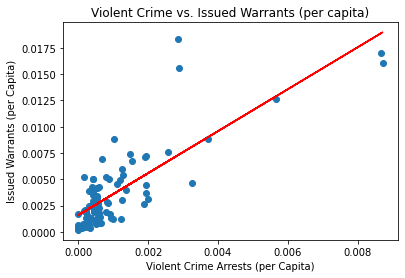

In [100]:
plt.scatter(x = final_annual_data['Violent crime']/final_annual_data['total total'], y = final_annual_data['Issued Warrants']/final_annual_data['total total'])
plt.title('Violent Crime vs. Issued Warrants (per capita)')
plt.xlabel('Violent Crime Arrests (per Capita)')
plt.ylabel('Issued Warrants (per Capita)')
#adding line of best fit
a,b = np.polyfit(final_annual_data['Violent crime']/final_annual_data['total total'],y = final_annual_data['Issued Warrants']/final_annual_data['total total'], deg = 1)
plt.plot(final_annual_data['Violent crime']/final_annual_data['total total'], a*final_annual_data['Violent crime']/final_annual_data['total total'] + b, color = 'red')
plt.show()